In [1]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
import SimpleITK as sitk
import pandas as pd


# Extract a certain feature from the images in folders

The code below extracted the SizeZoneNonUniformity feature from the folders named "pos" and 'neg', which stored Lung CT scans with Positive or Negative COVID-19 labels 

In [2]:
dict = './covid19/kcv/'

# Function takes a list of folders, extract features from it, change the extractor inside function and the return dictionary
# to run exactly which feature, the key of the return dictionary can be found in mask.ipy and also listed in pyradiomics library
def LoadDataFromImages(foldernames):
    input_array = []
    output_array=[]

    extractor = RadiomicsFeatureExtractor()
    # Disable all classes except firstorder
    extractor.disableAllFeatures()
    
    extractor.enableFeaturesByName(glszm=['SizeZoneNonUniformity'])

    for i in foldernames:
        files  = sorted(os.listdir(dict + i))
        for j in files:
            im = sitk.ReadImage(dict + i +'/' + j)
            
            # reshape and fill the input array
            input_array.append(sitk.GetArrayFromImage(im).reshape(512,512,1))
            
            ma_arr = np.ones(im.GetSize()[::-1])  # reverse the order as image is xyz, array is zyx
            ma = sitk.GetImageFromArray(ma_arr)
            ma.CopyInformation(im)  # Copy geometric info
            
            # extract features and fill the output array
            features = extractor.execute(im, ma)
            
            output_array.append(features['original_glszm_SizeZoneNonUniformity'])

            
    return input_array,output_array

In [3]:
input_array, output_array = LoadDataFromImages(["pos", "neg"])

We can store the extracted feature using numpy arrays

In [ ]:
np.save("original_glszm_SizeZoneNonUniformity.npy",np.array(output_array))

# Load the Training and Testing Data

We load CT scans from two folders, also I sorted the return list just keep the load in the same order

In [5]:
# label index 0 is positive, 1 is negative
class_names = ['pos', 'neg']
dict = './covid19/kcv/'

In [6]:

def load_training():
    trainingdata = []
    for i in class_names:
        path = os.path.join(dict, i)
        label_num = class_names.index(i)
        for j in sorted(os.listdir(path)):
            img = sitk.ReadImage(dict + i +'/' + j)
            trainingdata.append([sitk.GetArrayFromImage(img).reshape(512,512,1),label_num])
            
    return trainingdata
    
            
    

In [7]:
data= load_training()

In [8]:
len(data)

8000

After loading total 8000 images, divide the images to a list and the corresponding label to a list

In [9]:
X =[]
Y =[]

for trainingx, label in data:
    X.append(trainingx)
    Y.append(label)


We load the features we previous extracted from the images (processure from the above session)

In [3]:
feature_arr1 = np.load('original_firstorder_Skewness.npy') 
feature_arr2 = np.load('original_glcm_Autocorrelation.npy')  
feature_arr3 = np.load('original_glrlm_GrayLevelVariance.npy') 
feature_arr4 = np.load('original_glszm_SizeZoneNonUniformity.npy')  
feature_arr5 = np.load('original_glcm_ClusterShade.npy')  
feature_arr6 = np.load('original_glcm_DifferenceEntropy.npy')

Apply to k fold groups, in this case I am using n =10,
then i am going to prepare the input and the output data for the 10 groups

In [10]:
kfold = KFold(10,shuffle=True,random_state=1)

traingroup = []
testgroup=[]

feature1_train= []
feature2_train= []
feature3_train= []
feature4_train= []
feature5_train= []
feature6_train= []


feature1_test= []
feature2_test= []
feature3_test= []
feature4_test= []
feature5_test= []
feature6_test= []


output_label_train = []
output_label_test = []




# split data to 10 train and test set
for train, test in kfold.split(X):
    per_train_group = []
    per_test_group=[]
    
    per_feature1_train = []
    per_feature2_train = []
    per_feature3_train = []
    per_feature4_train = []
    per_feature5_train = []
    per_feature6_train = []
    
    per_feature1_test = []
    per_feature2_test = []
    per_feature3_test = []
    per_feature4_test = []
    per_feature5_test = []
    per_feature6_test = []

    
    per_label_train =[]
    per_label_test = []
    
    for i in train:
        per_train_group.append(X[i])
        per_label_train.append(Y[i])
        per_feature1_train.append(feature_arr1[i])
        per_feature2_train.append(feature_arr2[i])
        per_feature3_train.append(feature_arr3[i])
        per_feature4_train.append(feature_arr4[i])
        per_feature5_train.append(feature_arr5[i])
        per_feature6_train.append(feature_arr6[i])
    for i in test:
        per_test_group.append(X[i])
        per_label_test.append(Y[i])
        per_feature1_test.append(feature_arr1[i])
        per_feature2_test.append(feature_arr2[i])
        per_feature3_test.append(feature_arr3[i])
        per_feature4_test.append(feature_arr4[i])
        per_feature5_test.append(feature_arr5[i])
        per_feature6_test.append(feature_arr6[i])

    traingroup.append(per_train_group)
    testgroup.append(per_test_group)
    
    feature1_train.append(per_feature1_train)
    feature2_train.append(per_feature2_train)
    feature3_train.append(per_feature3_train)
    feature4_train.append(per_feature4_train)
    feature5_train.append(per_feature5_train)
    feature6_train.append(per_feature6_train)

    feature1_test.append(per_feature1_test)
    feature2_test.append(per_feature2_test)
    feature3_test.append(per_feature3_test)
    feature4_test.append(per_feature4_test)
    feature5_test.append(per_feature5_test)
    feature6_test.append(per_feature6_test)
    
    output_label_train.append(per_label_train)
    output_label_test.append(per_label_test)


After divide them into groups, convert them into numpy arrays

In [11]:
traingroup = np.array(traingroup)
testgroup= np.array(testgroup)

feature1_train= np.array(feature1_train)
feature2_train= np.array(feature2_train)
feature3_train= np.array(feature3_train)
feature4_train= np.array(feature4_train)
feature5_train= np.array(feature5_train)
feature6_train= np.array(feature6_train)
feature7_train= np.array(feature7_train)

feature1_test= np.array(feature1_test)
feature2_test= np.array(feature2_test)
feature3_test= np.array(feature3_test)
feature4_test= np.array(feature4_test)
feature5_test= np.array(feature5_test)
feature6_test= np.array(feature6_test)
feature7_test= np.array(feature7_test)

output_label_train = np.array(output_label_train)
output_label_test = np.array(output_label_test)


# Regular Neural network with Random initialization

Construct a convolutional neural network that passing the images in and train for output label

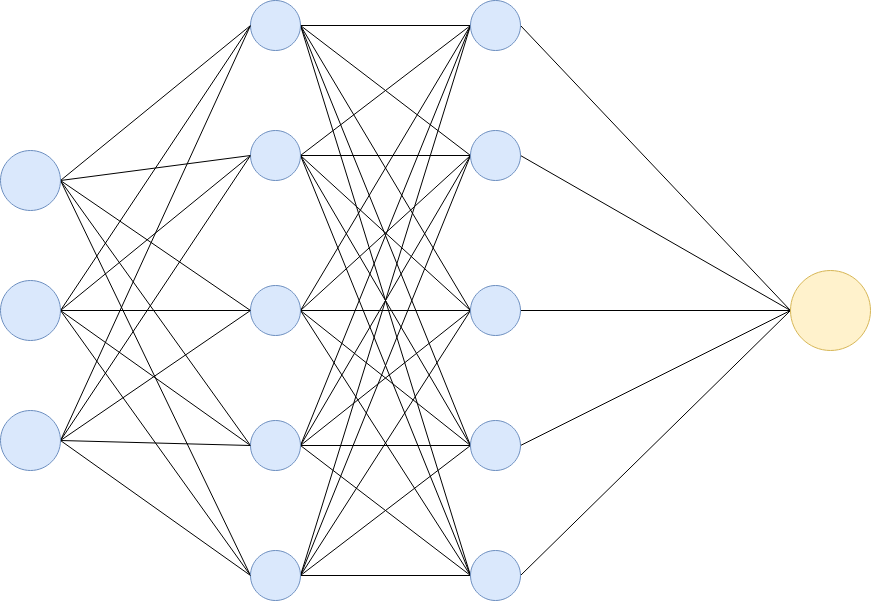

In [15]:
def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    x = Conv2D(64,(3,3), strides=(1, 1), activation='relu')(input_layer)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x)
    x1 = Conv2D(64,(3,3), strides=(1, 1), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x1)


    flat = Flatten()(pool2)
    d1 = Dense(147, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(flat)

    out = Dense(1, activation = 'sigmoid', name= modelname)(d1)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [16]:
RNNModel = MakeModel('RNNModel')

In [17]:
RNNModel.summary()

Model: "RNNModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 510, 510, 64)      640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 255, 255, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 253, 253, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1016064)           0  

In [18]:
RNNModel.compile(optimizer=tf.keras.optimizers.Adam(
),
              loss=tf.keras.losses.BinaryCrossentropy()
                 ,
              metrics=['accuracy',tf.keras.metrics.AUC(    
 )]
                   )

In [19]:
filename='RNNs.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [20]:
history_rnn = RNNModel.fit(traingroup[9], output_label_train[9], 
                validation_data=([testgroup[9],output_label_test[9]]), 
                batch_size=64,
                epochs=10,
                          callbacks=[history_logger],
                          shuffle = True)


Epoch 1/10
113/113 [==============================] - 24s 211ms/step - loss: 84.9809 - accuracy: 0.9615 - auc_2: 0.9104 - val_loss: 0.1177 - val_accuracy: 0.9712 - val_auc_2: 0.9521
Epoch 2/10
113/113 [==============================] - 23s 208ms/step - loss: 0.0348 - accuracy: 0.9893 - auc_2: 0.9937 - val_loss: 0.1112 - val_accuracy: 0.9762 - val_auc_2: 0.9615
Epoch 3/10
113/113 [==============================] - 23s 208ms/step - loss: 0.0206 - accuracy: 0.9943 - auc_2: 0.9970 - val_loss: 0.0759 - val_accuracy: 0.9800 - val_auc_2: 0.9771
Epoch 4/10
113/113 [==============================] - 23s 208ms/step - loss: 0.0060 - accuracy: 0.9981 - auc_2: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9925 - val_auc_2: 0.9989
Epoch 5/10
113/113 [==============================] - 23s 207ms/step - loss: 0.0043 - accuracy: 0.9989 - auc_2: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9925 - val_auc_2: 0.9901
Epoch 6/10
113/113 [==============================] - 23s 208ms/step - loss: 0.0055 - accuracy

# Simple models with raw features

The model using the extracted features as input and training for a output label

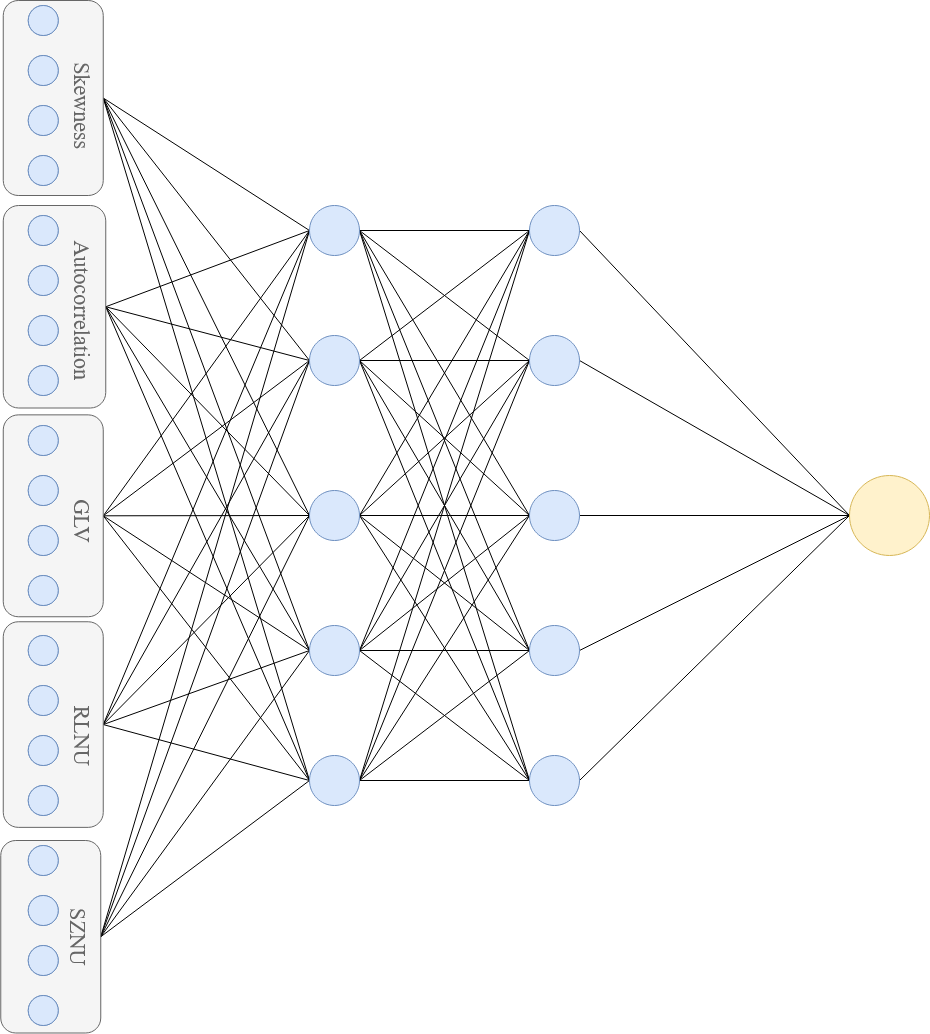

In [59]:
testgroup_num = 9
features_train = np.stack((feature1_train[testgroup_num],feature2_train[testgroup_num],feature3_train[testgroup_num], feature4_train[testgroup_num], feature5_train[testgroup_num], feature6_train[testgroup_num]),axis=1)
features_test = np.stack((feature1_test[testgroup_num],feature2_test[testgroup_num],feature3_test[testgroup_num], feature4_test[testgroup_num], feature5_test[testgroup_num], feature6_test[testgroup_num]),axis=1)

In [60]:
features_train.shape

(7200, 6)

In [61]:


def MakeModel(modelname):
    input_layer = keras.Input(shape=(6))

    
    #x = Flatten()(n_d)
    #x = BatchNormalization(axis=1)(x)
    x = Dense(5096, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(input_layer)
    x = Dense(5096, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(5096, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(5096, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(5096, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(1024, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)


    out = Dense(1, activation = 'sigmoid', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [62]:
rawFeatureModel = MakeModel('rawFeatures')

In [63]:
rawFeatureModel.summary()

Model: "rawFeatures"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_105 (Dense)           (None, 5096)              35672     
                                                                 
 dense_106 (Dense)           (None, 5096)              25974312  
                                                                 
 dense_107 (Dense)           (None, 5096)              25974312  
                                                                 
 dense_108 (Dense)           (None, 5096)              25974312  
                                                                 
 dense_109 (Dense)           (None, 5096)              25974312  
                                                                 
 dense_110 (Dense)           (None, 2048)              

In [64]:
filename='raws.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [65]:
rawFeatureModel.compile(optimizer=tf.keras.optimizers.Adam(
),
              loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy',tf.keras.metrics.AUC(  
)]
                )

In [66]:
history_rawFeature= rawFeatureModel.fit(features_train, output_label_train[testgroup_num], 
                validation_data=([features_test,output_label_test[testgroup_num]]), 
                batch_size=64,
                epochs=10,
                                       callbacks=[history_logger])

Epoch 1/10
113/113 [==============================] - 3s 19ms/step - loss: 84.5248 - accuracy: 0.8386 - auc_7: 0.5949 - val_loss: 0.3996 - val_accuracy: 0.8587 - val_auc_7: 0.6611
Epoch 2/10
113/113 [==============================] - 2s 15ms/step - loss: 0.3574 - accuracy: 0.8900 - auc_7: 0.6117 - val_loss: 0.3853 - val_accuracy: 0.8587 - val_auc_7: 0.6925
Epoch 3/10
113/113 [==============================] - 2s 15ms/step - loss: 0.3125 - accuracy: 0.8997 - auc_7: 0.6563 - val_loss: 0.4690 - val_accuracy: 0.8587 - val_auc_7: 0.6604
Epoch 4/10
113/113 [==============================] - 2s 15ms/step - loss: 0.4427 - accuracy: 0.8737 - auc_7: 0.5813 - val_loss: 0.3499 - val_accuracy: 0.8737 - val_auc_7: 0.7556
Epoch 5/10
113/113 [==============================] - 2s 15ms/step - loss: 0.3255 - accuracy: 0.9013 - auc_7: 0.6409 - val_loss: 0.3211 - val_accuracy: 0.9000 - val_auc_7: 0.7330
Epoch 6/10
113/113 [==============================] - 2s 15ms/step - loss: 0.3164 - accuracy: 0.9083 - a

# FINs

A essemble of FINs

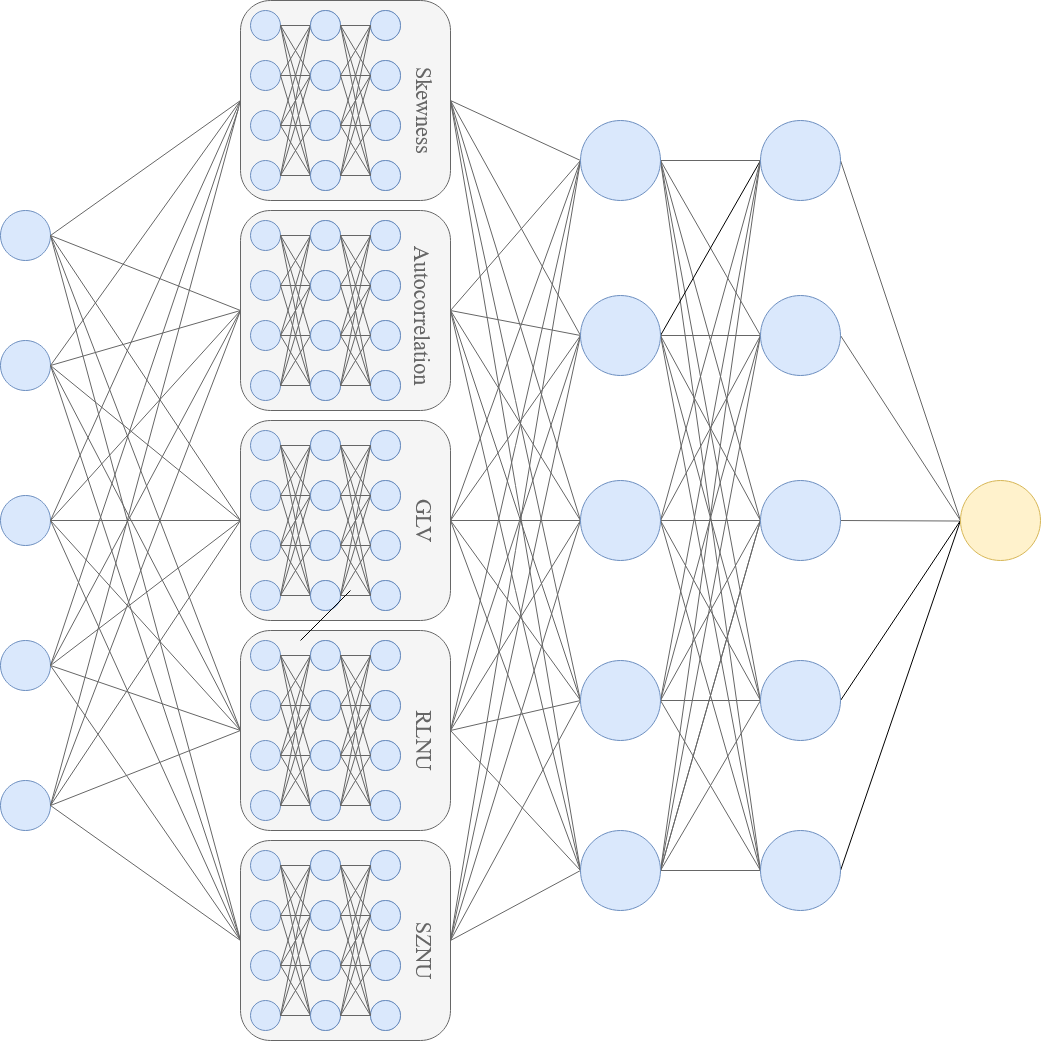

Fine-Tune witth images, load the real extracted features from fine-tune dataset, and fine-tune the model

In [77]:
inp = np.load('input_array.npy')
oup = np.load('ClusterShade10.npy')

In [177]:
input_array = inp[9]
output_array = oup[9]

In [178]:
base_model =  load_model("radiomics_glcm_ClusterShade.h5")

In [179]:
base_model.summary()

Model: "ClusterShade"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 flatten_4 (Flatten)         (None, 262144)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 262144)           1048576   
 hNormalization)                                                 
                                                                 
 dense_26 (Dense)            (None, 64)                16777280  
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                      

In [180]:
# how many layers for saving
newlayers = base_model.layers[9].output
n1 = Dense(64, activation='relu',name = '1')(newlayers)
out = Dense(1, activation='linear',name='2')(n1)
new_model = keras.Model(base_model.input, outputs = out)

In [181]:
new_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 flatten_4 (Flatten)         (None, 262144)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 262144)           1048576   
 hNormalization)                                                 
                                                                 
 dense_26 (Dense)            (None, 64)                16777280  
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                          

In [182]:
for i in range(len(base_model.layers)): 
    keras.layers.trainable = True   # True--> fine tine, False-->frozen

In [183]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/ClusterShade10', histogram_freq=1, profile_batch = 0
)

#https://github.com/tensorflow/tensorflow/issues/39755

In [184]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.001
), loss="mse")

In [2]:
new_model.fit(input_array, output_array, 
              epochs=20, 
          batch_size=64,
                shuffle=True
             # ,callbacks = tensorboard_callback
            )

In [186]:
new_model.save("./ClusterShade10.h5")

The part we load the FINs attacted to a DFNN and compare with the performance

In [12]:
# loading FINs

# load the 6 Fins to attach
m1 = load_model('Skewness5.h5')
m2 = load_model('Autocorrelation5.h5')
m3 = load_model('GrayLevelVariance5.h5')
m4 = load_model('SizeZoneNonUniformity5.h5')
m5 = load_model('ClusterShade5.h5')
m6 = load_model('DifferenceEntropy5.h5')

m1._name = 'feature1'
m2._name = 'feature2'
m3._name = 'feature3'
m4._name = 'feature4'
m5._name = 'feature5'
m6._name = 'feature6'

def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    
    l1 = m1(input_layer)
    l2 = m2(input_layer)
    l3 = m3(input_layer)
    l4 = m4(input_layer)
    l5 = m5(input_layer)
    l6 = m6(input_layer)
    
    # Attacted a CNN portion with the FINs
    
    x = Conv2D(64,(3,3), strides=(1, 1), activation='relu')(input_layer)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x)
    x1 = Conv2D(64,(3,3), strides=(1, 1), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x1)
    
    flat = Flatten()(pool2)
    
    n_d = concatenate([l1
                       ,l2
                       ,l3
                      ,l4
                       ,l5, l6
                        , flat
                      ])

    d1 = Dense(32, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal()
         ,name='dense_N_1')(n_d)
    
    d2 = Dense(32, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal()
     ,name='dense_N_2')(d1)
    d2 = Dense(32, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal()
     ,name='dense_N_3')(d2)
    

    out = Dense(1, activation = 'sigmoid', name= modelname)(d2)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [13]:
FinModel = MakeModel('Fin')

In [14]:
FinModel.summary()

Model: "Fin"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 510, 510, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 255, 255, 64  0          ['conv2d_2[0][0]']               
                                )                                                               

In [15]:
filename='FIN8.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [17]:
FinModel.compile(optimizer=tf.keras.optimizers.Adam(
     #learning_rate= 0.01
),
              loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy',tf.keras.metrics.AUC()]
                   )

In [18]:
history_fin = FinModel.fit(traingroup[7], output_label_train[7], 
                validation_data=([testgroup[7],output_label_test[7]]), 
                batch_size=64,
                epochs=10, callbacks=[history_logger],
                          shuffle = True)

Epoch 1/10
113/113 [==============================] - 28s 223ms/step - loss: 4.9395 - accuracy: 0.9036 - auc_4: 0.7572 - val_loss: 0.0329 - val_accuracy: 0.9937 - val_auc_4: 0.9974
Epoch 2/10
113/113 [==============================] - 24s 217ms/step - loss: 0.0284 - accuracy: 0.9921 - auc_4: 0.9964 - val_loss: 0.0290 - val_accuracy: 0.9925 - val_auc_4: 1.0000
Epoch 3/10
113/113 [==============================] - 25s 217ms/step - loss: 0.0044 - accuracy: 0.9987 - auc_4: 0.9994 - val_loss: 0.0029 - val_accuracy: 0.9987 - val_auc_4: 1.0000
Epoch 4/10
113/113 [==============================] - 25s 218ms/step - loss: 2.8558e-04 - accuracy: 1.0000 - auc_4: 1.0000 - val_loss: 7.0297e-04 - val_accuracy: 1.0000 - val_auc_4: 1.0000
Epoch 5/10
113/113 [==============================] - 25s 218ms/step - loss: 2.5498e-05 - accuracy: 1.0000 - auc_4: 1.0000 - val_loss: 7.1515e-04 - val_accuracy: 1.0000 - val_auc_4: 1.0000
Epoch 6/10
113/113 [==============================] - 25s 217ms/step - loss: 1.